# Topic1. A* path planning

If you got the point for problem definition in AIMA textbook, please execute and run the block until section 1-4

## 1-1. Import python package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import heapq
import math
import sys
from collections import defaultdict, deque, Counter
from itertools import combinations

## 1-2. Problem abstract & State-space tree node & queue

In [2]:
class Problem(object):
    """The abstract class for a formal problem. A new domain subclasses this,
    overriding `actions` and `results`, and perhaps other methods.
    Subclasses can add other keywords besides initial and goal.
    The default heuristic is 0 and the default step cost is 1 for all states."""

    def __init__(self, initial=None, goal=None, **kwds): 
        self.__dict__.update(initial=initial, goal=goal, **kwds) 
    
    
    def actions(self, state):           raise NotImplementedError
    def result(self, state, action):    raise NotImplementedError
    def is_goal(self, state):           return state == self.goal
    def step_cost(self, s, action, s1): return 1
    def h(self, node):                  return 0
    
    def __str__(self):
        return '{}({}, {})'.format(type(self).__name__, self.initial, self.goal)
    

class Node:
    "A Node in a search tree."
    def __init__(self, state, parent=None, action=None, path_cost=0):
        self.__dict__.update(state=state, parent=parent, action=action, path_cost=path_cost)

    def __repr__(self): return '<{}>'.format(self.state)
    def __len__(self): return 0 if self.parent is None else (1 + len(self.parent))
    def __lt__(self, other): return self.path_cost < other.path_cost
    
    
failure = Node('failure', path_cost=float('inf')) # Indicates an algorithm couldn't find a solution.
cutoff  = Node('cutoff',  path_cost=float('inf')) # Indicates iterative deepening search was cut off.
    
    
def expand(problem, node):
    "Expand a node, generating the children nodes."
    s = node.state
    for action in problem.actions(s):
        s1 = problem.result(s, action)
        cost = node.path_cost + problem.step_cost(s, action, s1)
        yield Node(s1, node, action, cost)
        

def path_actions(node):
    "The sequence of actions to get to this node."
    return [] if node.parent is None else path_actions(node.parent) + [node.action]


def path_states(node):
    "The sequence of states to get to this node."
    if node in (cutoff, failure, None): return []
    return path_states(node.parent) + [node.state]

In [3]:
FIFOQueue = deque

LIFOQueue = list

class PriorityQueue:
    """A queue in which the item with minimum f(item) is always popped first."""

    def __init__(self, items=(), key=lambda x: x): 
        self.key = key
        self.items = [] # a heap of (score, item) pairs
        for item in items:
            self.add(item)
         
    def add(self, item):
        """Add item to the queuez."""
        pair = (self.key(item), item)
        heapq.heappush(self.items, pair)

    def pop(self):
        """Pop and return the item with min f(item) value."""
        return heapq.heappop(self.items)[1]
    
    def top(self): return self.items[0][1]

    def __len__(self): return len(self.items)

## 1-3. Search methods

In [4]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first."
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    reached = {}
    while frontier:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if s not in reached or child.path_cost < reached[s].path_cost:
                reached[s] = child
                frontier.add(child)
    return failure


def uniform_cost_search(problem):
    "Search nodes with minimum  path cost first."
    return best_first_search(problem, f=lambda node: node.path_cost)


def astar_search(problem, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda node: node.path_cost + h(node))


def weighted_astar_search(problem, weight=1.4, h=None):
    """Search nodes with minimum f(n) = g(n) + h(n)."""
    h = h or problem.h
    return best_first_search(problem, f=lambda node: node.path_cost + weight * h(node))

## 1-4. Grid Problem

In [5]:
class GridProblem(Problem):
    """Finding a path on a 2D grid with obstacles. Obstacles are (x, y) cells."""
    
    def __init__(self, initial=(10, 30), goal=(130, 30), obstacles=(), **kwds):
        Problem.__init__(self, initial=initial, goal=goal, 
                         obstacles=set(obstacles) - {initial, goal}, **kwds)
        
        self.step_size = 2
#         unit_vector = [(-1, -1), (0, -1), (1, -1),
#                         (-1, 0),           (1,  0),
#                         (-1, +1), (0, +1), (1, +1)]
#         self.directions = [(step[0] * self.step_size, step[1] * self.step_size) for step in unit_vector]
        self.directions = [(-1, -1), (0, -1), (1, -1),
                        (-1, 0),           (1,  0),
                        (-1, +1), (0, +1), (1, +1)]

        
    
    def step_cost(self, s, action, s1): return straight_line_distance(s, s1)
    
    def h(self, node): return straight_line_distance(node.state, self.goal)
                  
    def result(self, state, action): 
        "Both states and actions are represented by (x, y) pairs."
        return action if action not in self.obstacles else state
    
    def actions(self, state):
        """You can move one cell in any of `directions` to a non-obstacle cell."""
        x, y = state
#         action_list = []
#         for (step_x, step_y) in self.directions:
#             (dx, dy) = (step_x/self.step_size, step_y/self.step_size)
#             cnt = 0
#             while(cnt < self.step_size):
#                 if (x + dx*cnt, y + dy*cnt) in self.obstacles:
#                     break
#                 else: 
#                     action_list.append((x + step_x, y + step_y))
#                     break
#                 cnt = cnt + 1
                
#         return action_list
        return [(x + dx, y + dy) for (dx, dy) in self.directions
                if (x + dx, y + dy) not in self.obstacles]
    
    def is_goal(self, state):
        cur_loc = state
        goal_loc = self.goal             
        return straight_line_distance(cur_loc, goal_loc) < self.step_size


## Function for creating obstacle

In [6]:
# The following can be used to create obstacles:
def straight_line_distance(point1, point2):
    "Straight-line distance between two 2D points."
    return abs(complex(*point1) - complex(*point2))
    

def random_lines(X=range(150), Y=range(60), N=150, lengths=range(6, 12), dirs=((0, 1), (1, 0))):
    """Yield the cells in N random lines of the given lengths."""
    for _ in range(N):
        x, y = random.choice(X), random.choice(Y)
        dx, dy = random.choice(dirs)
        for obj_line in line(x, y, dx, dy, random.choice(lengths)):
            yield obj_line            
            
def line(x, y, dx, dy, length):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    return {(x + i * dx, y + i * dy) for i in range(length)}

def random_blocks(X=range(150), Y=range(60), N=10, lengths=range(6, 12), dirs=((0, 1), (1, 0))):
    """A line of `length` cells starting at (x, y) and going in (dx, dy) direction."""
    for _ in range(N):
        x1, y1 = random.choice(X), random.choice(Y)
        dx, dy = random.choice(lengths), random.choice(lengths)
        
        for obj_line in line(x1, y1, 1, 0, dx+1):
            yield obj_line
        for obj_line in line(x1, y1+dy, 1, 0, dx+1):
            yield obj_line
        for obj_line in line(x1, y1, 0, 1, dy):
            yield obj_line
        for obj_line in line(x1+dx, y1, 0, 1, dy):
            yield obj_line

## Search algorithms declaration

In [7]:
def best_first_search(problem, f):
    "Search nodes with minimum f(node) value first; make `reached` global."
    global reached # <<<<<<<<<<< Only change here
    frontier = PriorityQueue([Node(problem.initial)], key=f)
    reached = {}
    while len(frontier) != 0:
        node = frontier.pop()
        if problem.is_goal(node.state):
            return node
        for child in expand(problem, node):
            s = child.state
            if (s not in reached) or (child.path_cost < reached[s].path_cost):
                reached[s] = child
                frontier.add(child)
    return failure

def plot_grid_problem(grid_problem, solution, reached=(), title='Search'):
    "Use matplotlib to plot the grid, obstacles, solution, and reached."
    plt.figure(figsize=(15, 6))
    plt.axis('off'); plt.axis('equal')
    
    # plot obstacle
    obs_list = list(grid_problem.obstacles)
    for point in obs_list:
        plt.scatter(point[0], point[1], marker='s', color='darkgrey')
    
    # plot initial position and goal
    plt.scatter(grid_problem.initial[0], grid_problem.initial[1], 11**2, marker='D', c='green')
    plt.text(grid_problem.initial[0]+2, grid_problem.initial[1]+2, 'current_loc')
    plt.scatter(grid_problem.goal[0], grid_problem.goal[1], 10**2, marker='D', c='red')
    plt.text(grid_problem.goal[0]+2, grid_problem.goal[1]+2, 'goal_loc')
    
    # plot reached path
    reached_list = list(reached)
    for point in reached_list:
        plt.scatter(point[0], point[1], 1**2, marker='.', c='blue')
    
    # plot solution path
    traj_list = list(path_states(solution))
    for point in traj_list:
        plt.scatter(point[0], point[1], marker='s', c='black')

    plt.show()
    print('{} {} search: {:.1f} path cost, {:,d} states reached'
          .format(' ' * 10, title, solution.path_cost, len(reached)))
    
def transpose(matrix): return list(zip(*matrix))

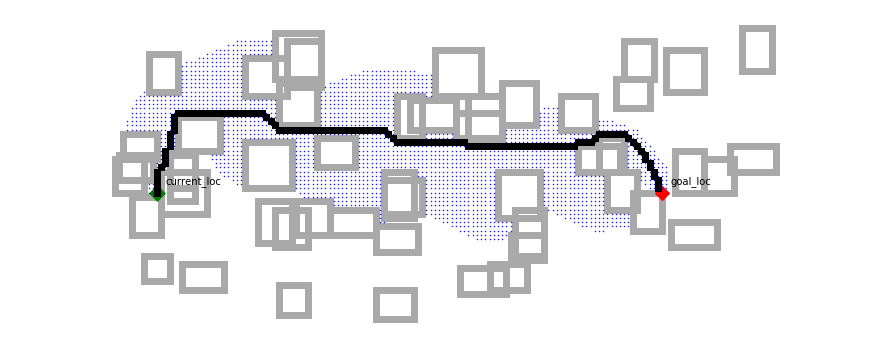

           Search search: 147.9 path cost, 2,178 states reached


In [8]:
# Test algorithm
d1 = GridProblem(initial=(10,30), obstacles=random_blocks(N=50))
plot_grid_problem(d1, astar_search(d1), reached)

<font color="red">
    
# ROS start here !!
</font>

In [9]:
import rospy
import tf
from nav_msgs.msg import Odometry, Path
from geometry_msgs.msg import PoseStamped
# from eric point

In [10]:
%%bash
source /opt/ros/kinetic/setup.sh
# export ROS_MASTER_URI=http:192.168.0.1:11311
export ROS_MASTER_URI=http:127.0.0.1:11311
echo $ROS_MASTER_URI

http:127.0.0.1:11311


In [11]:
rospy.init_node("Path_planning_node", anonymous = False)
path_pub = rospy.Publisher('/path', Path, queue_size=10)

Unable to register with master node [http://localhost:11311]: master may not be running yet. Will keep trying.


In [12]:
try:
    loc_msg = rospy.wait_for_message("/odom",
                                     topic_type=Odometry,
                                     timeout=5)
except:
    print("Can't get location messege in time!")

Can't get location messege in time!


In [13]:
initial_point = (20, 20)

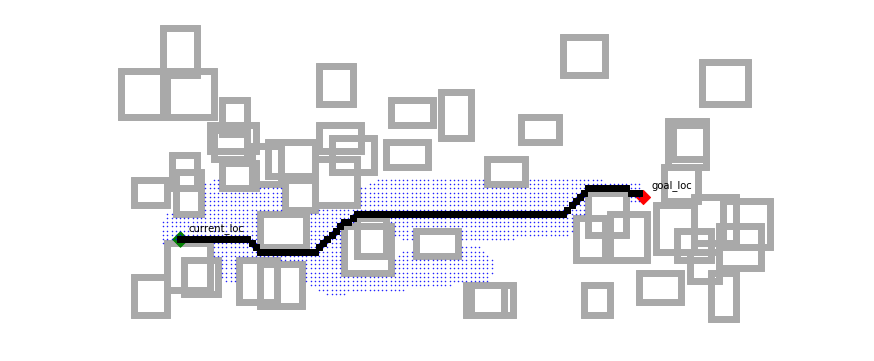

           Search search: 116.9 path cost, 1,483 states reached


In [14]:
gridproblem1 = GridProblem(initial=initial_point, obstacles=random_blocks(N=50))
solution = astar_search(gridproblem1)
plot_grid_problem(gridproblem1, solution, reached)

In [18]:
path = Path()
path.header.frame_id = 'odom'
path.header.stamp = rospy.Time.now()

traj_list = list(path_states(solution))
for i in range(len(traj_list)-1) :
    p = PoseStamped()
    p.header.frame_id = 'odom'
    p.header.stamp = rospy.Time.now()
    p.pose.position.x = traj_list[i][0]
    p.pose.position.y = traj_list[i][1]
    
    head_angle = math.atan2(traj_list[i+1][1] - traj_list[i][1],
                            traj_list[i+1][0] - traj_list[i][0])
    print(p.pose.position.x, p.pose.position.y, head_angle*180.0/math.pi)
    
    (p.pose.orientation.x, p.pose.orientation.y, p.pose.orientation.z, p.pose.orientation.w) = tf.transformations.quaternion_from_euler(0, 0, math.pi)
    path.poses = [p] + path.poses
        
path_pub.publish(path)


(20, 20, 0.0)
(21, 20, 0.0)
(22, 20, 0.0)
(23, 20, 0.0)
(24, 20, 0.0)
(25, 20, 0.0)
(26, 20, 0.0)
(27, 20, 0.0)
(28, 20, 0.0)
(29, 20, 0.0)
(30, 20, 0.0)
(31, 20, 0.0)
(32, 20, 0.0)
(33, 20, 0.0)
(34, 20, 0.0)
(35, 20, 0.0)
(36, 20, -45.0)
(37, 19, -45.0)
(38, 18, -45.0)
(39, 17, 0.0)
(40, 17, 0.0)
(41, 17, 0.0)
(42, 17, 0.0)
(43, 17, 0.0)
(44, 17, 0.0)
(45, 17, 0.0)
(46, 17, 0.0)
(47, 17, 0.0)
(48, 17, 0.0)
(49, 17, 0.0)
(50, 17, 0.0)
(51, 17, 0.0)
(52, 17, 45.0)
(53, 18, 45.0)
(54, 19, 45.0)
(55, 20, 45.0)
(56, 21, 45.0)
(57, 22, 45.0)
(58, 23, 45.0)
(59, 24, 0.0)
(60, 24, 45.0)
(61, 25, 45.0)
(62, 26, 0.0)
(63, 26, 0.0)
(64, 26, 0.0)
(65, 26, 0.0)
(66, 26, 0.0)
(67, 26, 0.0)
(68, 26, 0.0)
(69, 26, 0.0)
(70, 26, 0.0)
(71, 26, 0.0)
(72, 26, 0.0)
(73, 26, 0.0)
(74, 26, 0.0)
(75, 26, 0.0)
(76, 26, 0.0)
(77, 26, 0.0)
(78, 26, 0.0)
(79, 26, 0.0)
(80, 26, 0.0)
(81, 26, 0.0)
(82, 26, 0.0)
(83, 26, 0.0)
(84, 26, 0.0)
(85, 26, 0.0)
(86, 26, 0.0)
(87, 26, 0.0)
(88, 26, 0.0)
(89, 26, 0.0)
(90, 